In [3]:
import os
import cv2
import glob
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
import shutil
shutil.unpack_archive("/content/dataset.zip", "/content/dataset")

In [5]:
PATH = "/content/dataset/dataset"
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [6]:
def calculate_label(img_basename: str) -> int:
  '''
  a function for generating lebel for each image from its basename
  inputs:
  img_basename: a string shows an image name with its extention
  e.g. calculate_label('example.jpg')

  outputs:
  return label as an integer number for input image
  '''

  tmp = img_basename[:len(img_basename)-4].split("_")
  row = tmp[2]
  rod_id = int(tmp[3])
  if row in {"A", "B", "E", "F", "I", "J"}:
    label = 4-(rod_id % 4)
  else:
    label = (rod_id % 4)+1
  return label

In [20]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply transformations if any
        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

def create_dataset(path: str, test_split: float, b_sz: int):
    '''
    A function for creating dataset from path which is passed to it.
    - Reads images
    - Generates labels
    - Normalizes data
    - Converts labels to integers
    - Splits train and test data

    Inputs:
    path: str - Path to the folder containing images
    test_split: float - test split ratio
    b_sz: int - batch size

    Outputs:
    DataLoader instances for train and test sets
    '''
    imgs_path = glob.glob(os.path.join(path, "*.jpg"))

    # Generate labels based on filenames
    labels = [calculate_label(os.path.basename(img_path)) for img_path in imgs_path]
    # Normalize and transform images (resize and normalization)
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert to PIL
        transforms.Resize((64, 64)),  # Resize image to (64, 64)
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

    # Split into training and test datasets, set random seed
    X_train, X_test, Y_train, Y_test = train_test_split(
        imgs_path, labels, test_size=test_split, random_state=42, stratify=labels
    )

    # Convert lists of labels to numpy arrays
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

    # Convert label arrays to torch tensors
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    Y_test = torch.tensor(Y_test, dtype=torch.long)

    # Create Dataset objects for train and test sets
    train_dataset = ImageDataset(X_train, Y_train, transform=transform)
    test_dataset = ImageDataset(X_test, Y_test, transform=transform)

    # Create DataLoader for batching, shuffling, and loading data
    train_loader = DataLoader(train_dataset, batch_size=b_sz, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=b_sz, shuffle=False)

    return train_loader, test_loader


In [8]:
class MyModel(nn.Module):
    '''

    Create your own CNN model (with desired architecture)

    '''
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x64x64, Output: 32x64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128x8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),  # 128 channels * 8x8
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512, 5),  # Output: 5 classes (labels 0 to 4)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after the last time validation loss improved.
            verbose (bool): Whether to print out messages when stopping early.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.verbose:
                print(f"Early stopping triggered after {self.patience} epochs without improvement.")

In [21]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.01, patience=5):
    '''
    Training and validating loop. Return train and test losses and accs for plotting.

    Use proper loss function and optimizer on your own.

    Use lr scheduler and early stopping if needed.

    inputs:
      model (nn.module): CNN model
      train_loader (Dataloader): train dataset loader
      test_loader (Dataloader): test dataset loader
      epochs (int): number of total epochs
      lr (float): learning rate
      patience (int): early stop patience

    outputs:
      train_losses (list): list of avg train loss in each epoch
      train_accuracies (list): list of avg train acc in each epoch
      test_losses (list): list of avg test loss in each epoch
      test_accuracies (list): list of avg test acc in each epoch
    '''
    # Set up the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_val_loss = float('inf')  # For saving the best model

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Train for a specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training Loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)


            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Compute training loss and accuracy
        avg_train_loss = running_train_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Loop
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # No gradient calculation for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Compute test loss and accuracy
        avg_test_loss = running_test_loss / total_test
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        # Save the model if it has the best validation loss
        if avg_test_loss < best_val_loss:
            print(f"Saving model with better validation loss: {avg_test_loss:.4f}")
            best_val_loss = avg_test_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model


        # Call early stopping after each epoch
        early_stopping(avg_test_loss, model)

        # If early stopping is triggered, break the loop
        if early_stopping.early_stop:
            print("Early stopping")
            break


        # Print the train and test loss and accuracy for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

        # Call lr scheduler after each epoch
        scheduler.step(avg_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies


In [11]:
def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies):
    # Plot the loss curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [12]:
def plot_confusion_matrix(y_true, y_pred, num_classes):

    # calculate and plot confusion matrix

    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, eval_loader, num_classes=5):
    model.eval()  # Set the model to evaluation mode

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define loss function for calculating loss value on test data
    criterion = nn.CrossEntropyLoss()

    correct_eval = 0
    total_eval = 0
    running_eval_loss = 0.0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_eval_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)

            total_eval += labels.size(0)
            correct_eval += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

    eval_loss = running_eval_loss / total_eval
    eval_accuracy = 100 * correct_eval / total_eval

    print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.2f}%")

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, num_classes)


In [13]:
def load_model(model, filepath='best_model.pth'):
    model.load_state_dict(torch.load(filepath))  # Load model weights
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {filepath}")
    return model


In [22]:
train_loader, test_loader = create_dataset(PATH, VALIDATION_SPLIT, BATCH_SIZE)

In [27]:
model = MyModel()

In [28]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, epochs=EPOCHS)

Saving model with better validation loss: 1.3933
Epoch [1/100], Train Loss: 6.6792, Train Acc: 24.71%, Test Loss: 1.3933, Test Acc: 23.73%
Saving model with better validation loss: 1.3917
Epoch [2/100], Train Loss: 1.4134, Train Acc: 25.26%, Test Loss: 1.3917, Test Acc: 25.35%
Saving model with better validation loss: 1.3910
Epoch [3/100], Train Loss: 1.4056, Train Acc: 25.23%, Test Loss: 1.3910, Test Acc: 24.77%
Saving model with better validation loss: 1.3894
Epoch [4/100], Train Loss: 1.3990, Train Acc: 25.38%, Test Loss: 1.3894, Test Acc: 27.43%
Saving model with better validation loss: 1.2120
Epoch [5/100], Train Loss: 1.3579, Train Acc: 29.63%, Test Loss: 1.2120, Test Acc: 46.30%
Saving model with better validation loss: 1.0818
Epoch [6/100], Train Loss: 1.2468, Train Acc: 36.46%, Test Loss: 1.0818, Test Acc: 45.02%
Epoch [7/100], Train Loss: 1.1873, Train Acc: 41.35%, Test Loss: 1.1923, Test Acc: 45.72%
Saving model with better validation loss: 1.0587
Epoch [8/100], Train Loss: 

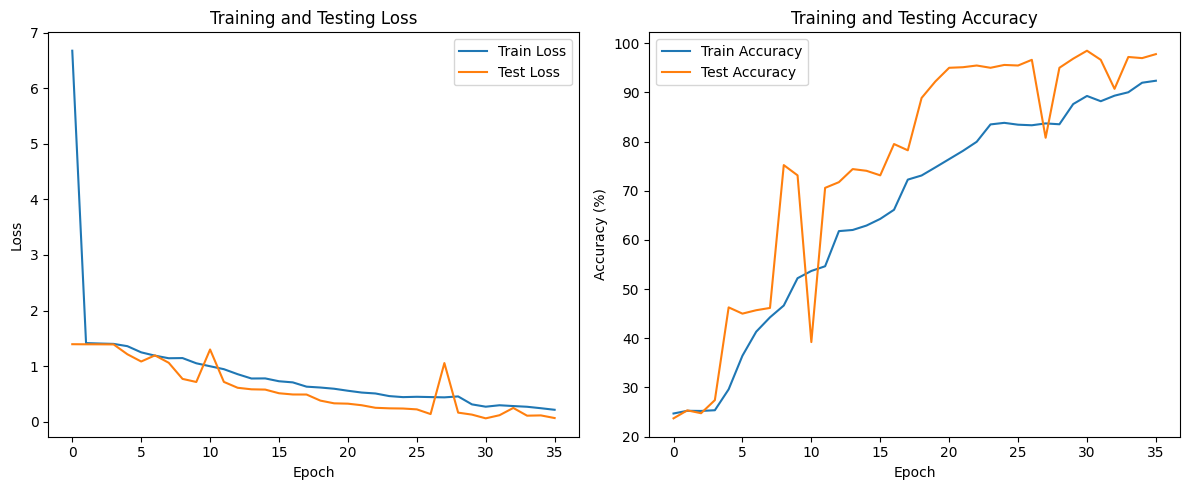

In [29]:
plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies)

In [30]:
best_model = load_model(model, 'best_model.pth')

Model loaded from best_model.pth


Evaluation Loss: 0.0582, Evaluation Accuracy: 98.50%


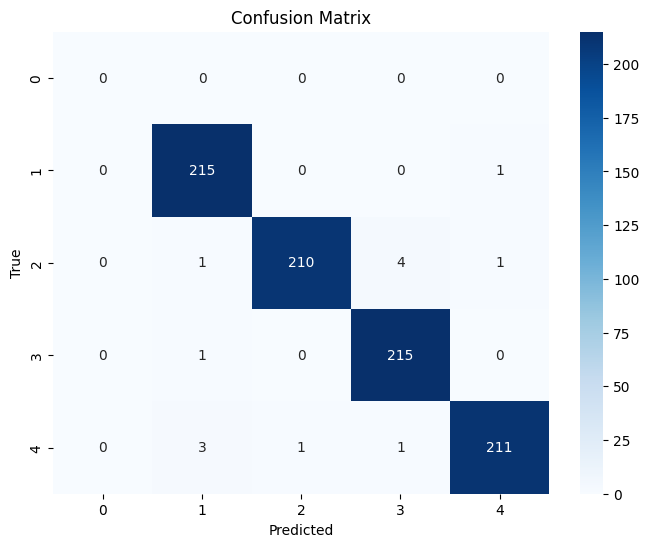

In [31]:
evaluate_model(best_model, test_loader)